In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_original = pd.read_csv(r"C:\Users\kgk.varma\Downloads\soil_measures.csv")

In [3]:
df = df_original.copy()

In [4]:
df.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [5]:
df.shape

(2200, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2200 non-null   int64  
 1   P       2200 non-null   int64  
 2   K       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB


In [7]:
df.describe()

,N,P,K,ph
count,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,6.469480
std,36.917334,32.985883,50.647931,0.773938
min,0.000000,5.000000,5.000000,3.504752
25%,21.000000,28.000000,20.000000,5.971693
50%,37.000000,51.000000,32.000000,6.425045
75%,84.250000,68.000000,49.000000,6.923643
max,140.000000,145.000000,205.000000,9.935091


In [8]:
df.duplicated().sum()

0

In [9]:
df.isnull().sum()

N       0
P       0
K       0
ph      0
crop    0
dtype: int64

In [10]:
X = df.drop('crop', axis=1) 
y = df['crop'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [12]:
final_features = ['K', 'N','P', 'ph']

# Producing a final model
X_train, X_test, y_train, y_test = train_test_split(df[final_features], df["crop"], test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=2000, multi_class="multinomial")
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
model_performance = f1_score(y_test, y_pred, average="weighted")
print(model_performance)

0.647422237577308


### Strategies to improve performence of model using feature engineering, hyperparameter tuning, model regularization, and even using alternative algorithms.

### Feature Engineering: Polynomial Features
Create polynomial features for each of the existing features (e.g., square or cube of 'N', 'K', etc.). This allows the model to capture more complex relationships between features.

In [39]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

log_reg.fit(X_train_poly, y_train)
y_pred = log_reg.predict(X_test_poly)
pf_model_performance = f1_score(y_test, y_pred, average="weighted")
print(pf_model_performance)

0.6354571503145485


### Feature Scaling:
Logistic regression models are sensitive to the scale of features. Standardizing the features (mean = 0, variance = 1) ensures that all features contribute equally to the model.

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
ss_model_performance = f1_score(y_test, y_pred, average="weighted")
print(ss_model_performance)

0.6360557133254062


### Hyperparameter Tuning:
Use cross-validation to find the optimal hyperparameters, such as C (inverse regularization strength) or solver. Grid search or randomized search can help with this.

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'sag', 'saga'],
    'max_iter': [1000, 2000]
}

grid_search = GridSearchCV(LogisticRegression(multi_class="multinomial"), param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
ht_model_performance = f1_score(y_test, y_pred, average="weighted")
print(f"Best parameters: {grid_search.best_params_}")
print(ht_model_performance)

Best parameters: {'C': 100, 'max_iter': 1000, 'solver': 'sag'}
0.6877321050585921


### Regularization:
Regularization techniques (L2 regularization, the default in LogisticRegression) can help prevent overfitting by penalizing large coefficients.
Adjust the regularization strength parameter C in the logistic regression model. A smaller C value (stronger regularization) can help simplify the model and avoid overfitting.

In [44]:
log_reg = LogisticRegression(max_iter=2000, multi_class="multinomial", C=0.1)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
reg_model_performance = f1_score(y_test, y_pred, average="weighted")
print(reg_model_performance)


0.5877974937062364


### Cross-Validation:
Instead of splitting the data once, use k-fold cross-validation to evaluate the model on different subsets of the data. This gives a better estimate of model performance and can prevent overfitting to the test set.

In [23]:
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression(max_iter=2000, multi_class="multinomial")
scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
print(f"Mean F1 score: {scores.mean()}")


Mean F1 score: 0.6842570777139014


### Alternative Algorithms:
If logistic regression is not giving satisfactory results, consider using more complex models such as random forests.

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
rf_model_performance = f1_score(y_test, y_pred, average="weighted")
print(rf_model_performance)


0.8229840919150099


### Alternative Algorithms: Decision Tree Classifier

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Instantiate the model
tree_clf = DecisionTreeClassifier(random_state=42)

# Fit the model
tree_clf.fit(X_train, y_train)

# Make predictions
y_pred = tree_clf.predict(X_test)

# Evaluate the performance
dtc_model_performance = f1_score(y_test, y_pred, average='weighted')
print(f"Decision Tree F1 score: {dtc_model_performance}")


Decision Tree F1 score: 0.7814485999517448


In [28]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Alternative Algorithms: xgboost 

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import f1_score

final_features = ['K', 'N', 'P', 'ph']
X_train, X_test, y_train, y_test = train_test_split(df[final_features], df["crop"], test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_clf = xgb.XGBClassifier(objective="multi:softmax", eval_metric="mlogloss", num_class=len(label_encoder.classes_), random_state=42)
xgb_clf.fit(X_train, y_train_encoded)

y_pred_encoded = xgb_clf.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the performance
xgb_model_performance = f1_score(y_test, y_pred, average='weighted')
print(f"XGBoost F1 score: {xgb_model_performance}")


XGBoost F1 score: 0.7903731381232454


### Handle Class Imbalance:
If your target variable ('crop') has imbalanced classes, you may need to adjust the class weights to prevent the model from being biased towards the majority class.

In [53]:
log_reg = LogisticRegression(max_iter=2000, multi_class="multinomial", class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
ci_model_performance = f1_score(y_test, y_pred, average="weighted")
print(ci_model_performance)


0.6360557133254062


## Model_performance

In [34]:
model_performance = {
    "Logistic Regression": model_performance,
    "Decision Tree": dtc_model_performance,
    "Random Forest": rf_model_performance,
    "XGBoost": xgb_model_performance,
    "Polynomial Features": pf_model_performance,
    "StandardScaler" : ss_model_performance,
    " Hyperparameter Tuning" :ht_model_performance,
    "Regularization" : reg_model_performance,
    "Class Imbalance": ci_model_performance,
}

# Convert to DataFrame for better visualization
performance_df = pd.DataFrame(model_performance.items(), columns=["Model", "F1 Score"])
print(performance_df)

                    Model  F1 Score
0     Logistic Regression  0.647422
1           Decision Tree  0.781449
2           Random Forest  0.807452
3                 XGBoost  0.790373
4     Polynomial Features  0.627035
5          StandardScaler  0.647521
6   Hyperparameter Tuning  0.687732
7          Regularization  0.587797
8         Class Imbalance  0.636056


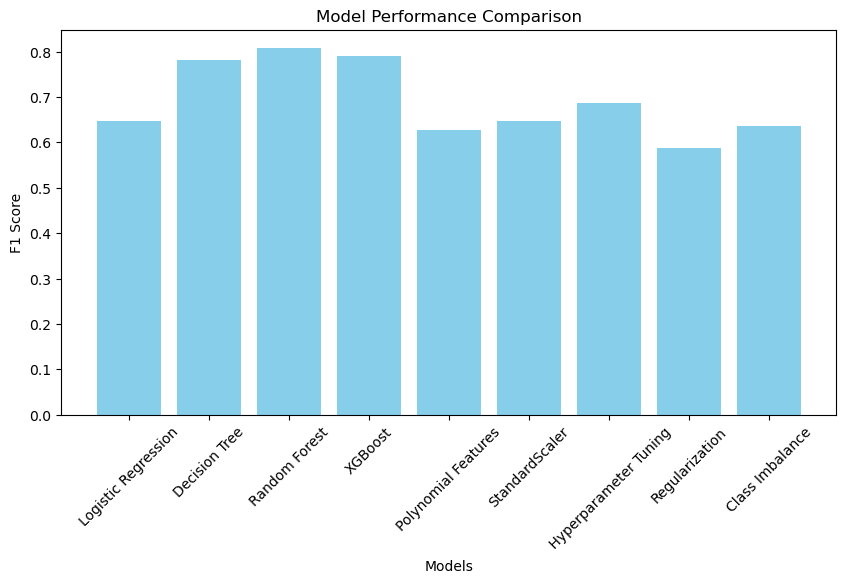

In [35]:
plt.figure(figsize=(10, 5))
plt.bar(performance_df['Model'], performance_df['F1 Score'], color='skyblue')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

From this hypothetical example:
Logistic regression with Hyperparameter tuning as a highest F1 score(compared to other strategies. As an Alternative models -The Random Forest model has the highest F1 score (0.81) and is therefore the best-performing model.
XGboost is the next best with an F1 score of 0.79.

In [37]:
new_data = {
    'K': [150, 200, 100],
    'N': [80, 90, 70],
    'P': [60, 70, 50],
    'ph': [6.5, 7.0, 6.0]
}

new_df = pd.DataFrame(new_data)

In [57]:
predictions = rf.predict(new_df)
predictions

array(['grapes', 'grapes', 'grapes'], dtype=object)